In [16]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import clear_output
%matplotlib inline

In [2]:
celebs = ['Irrfan_Khan', 'Jacqueline_Fernandez', 'Juhi_Chawla', 
          'Kajal_Aggarwal', 'Paresh_Rawal']

In [3]:
os.chdir('data/celeb_faces_dataset')
if os.path.isdir('train/Irrfan_Khan/') is False: 
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for c in celebs:
        shutil.move(f'{c}', 'train')
        os.mkdir(f'valid/{c}')
        os.mkdir(f'test/{c}')

        valid_samples = random.sample(os.listdir(f'train/{c}'), 30)
        for i in valid_samples:
            shutil.move(f'train/{c}/{i}', f'valid/{c}')

        test_samples = random.sample(os.listdir(f'train/{c}'), 5)
        for j in test_samples:
            shutil.move(f'train/{c}/{j}', f'test/{c}')
os.chdir('../..')

In [4]:
train_path = 'data/celeb_faces_dataset/train'
valid_path = 'data/celeb_faces_dataset/valid'
test_path = 'data/celeb_faces_dataset/test'

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)\
                .flow_from_directory(directory=train_path, target_size=(224,224), batch_size=5)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)\
                .flow_from_directory(directory=valid_path, target_size=(224,224), batch_size=5)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)\
               .flow_from_directory(directory=test_path, target_size=(224,224), batch_size=5, shuffle=False)

Found 278 images belonging to 5 classes.
Found 150 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


In [6]:
mobile = tf.keras.applications.mobilenet.MobileNet(weights = 'imagenet', include_top = False)
for layer in mobile.layers[:-10]:
    layer.trainable = False
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 

In [7]:
top_model = mobile.output

In [8]:
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation='relu')(top_model)
top_model = Dense(1024, activation='relu')(top_model)
top_model = Dense(512, activation='relu')(top_model)

In [9]:
top_model = Dense(units=5, activation='softmax')(top_model)

In [10]:
model = Model(inputs=mobile.input, outputs=top_model)

In [11]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)   

In [12]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [14]:
callbacks_list = [PlotLearning()]

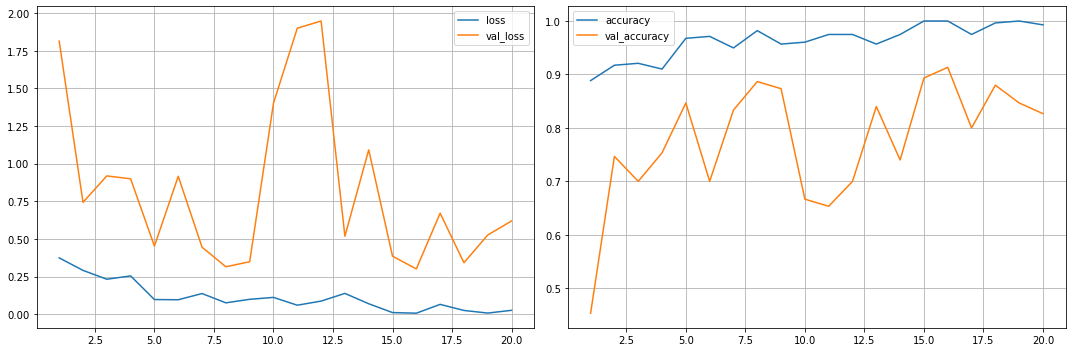

56/56 - 9s - loss: 0.0252 - accuracy: 0.9928 - val_loss: 0.6194 - val_accuracy: 0.8267


In [17]:
model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=20,
            verbose=2,
            callbacks=callbacks_list
)

In [18]:
test_labels = test_batches.classes

In [19]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [20]:
predictions

array([[9.9999952e-01, 3.6509294e-07, 7.8010407e-09, 9.3886115e-08,
        1.5052279e-08],
       [9.1615987e-01, 8.0828272e-02, 3.6684938e-05, 1.0076764e-03,
        1.9673533e-03],
       [9.9972147e-01, 4.0068120e-05, 1.2377908e-06, 1.7464772e-04,
        6.2686864e-05],
       [7.5547576e-01, 2.3942593e-01, 7.4307536e-05, 3.6220390e-03,
        1.4019527e-03],
       [9.9993837e-01, 5.4870896e-05, 1.5611197e-06, 4.1395288e-06,
        1.1118909e-06],
       [2.6576285e-07, 9.9840266e-01, 2.2441198e-07, 1.5967160e-03,
        9.1430067e-08],
       [6.3186750e-04, 9.8240775e-01, 8.8230493e-03, 6.5062582e-03,
        1.6311540e-03],
       [6.5883484e-07, 9.9997413e-01, 3.9963609e-08, 2.5035162e-05,
        1.6018453e-07],
       [1.8219867e-08, 9.9999976e-01, 2.6540862e-08, 2.3179010e-07,
        3.1694551e-09],
       [3.6861889e-05, 9.9506807e-01, 1.0378575e-04, 4.7515836e-03,
        3.9635539e-05],
       [7.0612208e-04, 1.5371327e-01, 2.3757419e-01, 6.0620773e-01,
        1.79

In [21]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [23]:
test_batches.class_indices

{'Irrfan_Khan': 0,
 'Jacqueline_Fernandez': 1,
 'Juhi_Chawla': 2,
 'Kajal_Aggarwal': 3,
 'Paresh_Rawal': 4}

Confusion matrix, without normalization
[[5 0 0 0 0]
 [0 5 0 0 0]
 [0 1 2 2 0]
 [0 1 0 4 0]
 [1 0 0 0 4]]


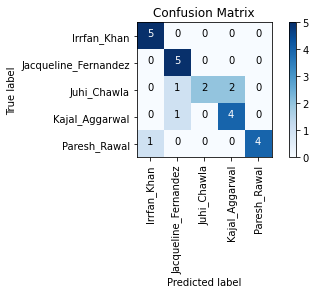

In [24]:
cm_plot_labels = celebs[:]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [25]:
#model.save('models\model_3_82.67_MobileNet.h5')